In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [66]:
solar_data = pd.read_csv('efficiency.csv')
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  3699 non-null   int64  
 1   Unnamed: 0    3699 non-null   int64  
 2   p_state       3699 non-null   object 
 3   p_county      3699 non-null   object 
 4   ylat          3699 non-null   float64
 5   xlong         3699 non-null   float64
 6   p_area        3699 non-null   int64  
 7   p_tech_sec    3699 non-null   object 
 8   p_axis        3436 non-null   object 
 9   p_azimuth     3699 non-null   int64  
 10  p_tilt        3265 non-null   float64
 11  p_cap_ac      3699 non-null   float64
 12  p_cap_dc      3699 non-null   float64
 13  p_type        3699 non-null   object 
 14  p_agrivolt    3699 non-null   object 
 15  p_zscore      3699 non-null   float64
 16  efficiency    3699 non-null   float64
dtypes: float64(7), int64(4), object(6)
memory usage: 491.4+ KB


In [67]:
solar_data['p_axis'] = solar_data['p_axis'].replace({
    'fixed-tilt,single-axis': 'combination',
    'fixed-tilt,single-axis,dual-axis': 'combination'
})
solar_data['p_axis'].value_counts()

p_axis
fixed-tilt     1975
single-axis    1430
dual-axis        25
combination       6
Name: count, dtype: int64

In [68]:
solar_data['p_type'] = solar_data['p_type'].replace({'landfill': 'landfill', 'landfill named': 'landfill',
                                                     'greenfield': 'greenfield',
                                                     'PCSC': 'contaminated', 'superfund': 'contaminated',
                                                     'RCRA': 'contaminated', 'AML': 'contaminated'})
(solar_data['p_type'].value_counts())

p_type
greenfield      3522
landfill         115
contaminated      62
Name: count, dtype: int64

In [69]:
solar_data['p_tech_sec'].value_counts()
solar_data['p_tech_sec'] = solar_data['p_tech_sec'].replace({
    'c-si': 'c-si',
    'thin film': 'thin-film',
    'unknown': 'unknown',
    'cpv': 'cpv',
    'c-si,thin-film': 'combination',
    'c-si,cpv': 'combination',
    'c-si,thin-film,cpv': 'combination'
})
# Verify the changes
print(solar_data['p_tech_sec'].value_counts())

p_tech_sec
c-si           2962
thin-film       396
unknown         333
combination       4
cpv               4
Name: count, dtype: int64


In [70]:
solar_data['p_agrivolt'] = (solar_data['p_agrivolt'].apply(lambda x: x if x == 'non-agrivoltaic' else 'agrivoltaic'))
solar_data['p_agrivolt'].value_counts()

p_agrivolt
non-agrivoltaic    3633
agrivoltaic          66
Name: count, dtype: int64

In [71]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  3699 non-null   int64  
 1   Unnamed: 0    3699 non-null   int64  
 2   p_state       3699 non-null   object 
 3   p_county      3699 non-null   object 
 4   ylat          3699 non-null   float64
 5   xlong         3699 non-null   float64
 6   p_area        3699 non-null   int64  
 7   p_tech_sec    3699 non-null   object 
 8   p_axis        3436 non-null   object 
 9   p_azimuth     3699 non-null   int64  
 10  p_tilt        3265 non-null   float64
 11  p_cap_ac      3699 non-null   float64
 12  p_cap_dc      3699 non-null   float64
 13  p_type        3699 non-null   object 
 14  p_agrivolt    3699 non-null   object 
 15  p_zscore      3699 non-null   float64
 16  efficiency    3699 non-null   float64
dtypes: float64(7), int64(4), object(6)
memory usage: 491.4+ KB


In [72]:
drop = [0, 1, 2, 3, 16]
cleaned_solar_data = solar_data.drop(solar_data.columns[drop], axis=1)
cleaned_solar_data.head()

,ylat,xlong,p_area,p_tech_sec,p_axis,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_type,p_agrivolt,p_zscore
0,45.257500,-93.788399,92600,c-si,single-axis,180,NaN,5.00,7.0,greenfield,non-agrivoltaic,0.142344
1,44.542000,-92.971703,93358,c-si,fixed-tilt,180,0.0,5.00,6.5,greenfield,non-agrivoltaic,0.003859
2,44.527100,-92.971802,93795,c-si,fixed-tilt,180,0.0,5.00,6.5,greenfield,non-agrivoltaic,-0.003666
3,45.458500,-93.272400,123941,c-si,fixed-tilt,180,NaN,6.62,8.8,greenfield,non-agrivoltaic,0.035805
4,44.114899,-91.791298,89591,c-si,fixed-tilt,180,30.0,4.80,7.0,greenfield,non-agrivoltaic,0.201243


In [73]:
cleaned_solar_data.dropna(inplace = True)
cleaned_solar_data['p_tech_sec'] = cleaned_solar_data['p_tech_sec'].astype('category')
cleaned_solar_data['p_axis'] = cleaned_solar_data['p_axis'].astype('category')
cleaned_solar_data['p_type'] = cleaned_solar_data['p_type'].astype('category')
cleaned_solar_data['p_agrivolt'] = cleaned_solar_data['p_agrivolt'].astype('category')
cleaned_solar_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008 entries, 1 to 3697
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ylat        3008 non-null   float64 
 1   xlong       3008 non-null   float64 
 2   p_area      3008 non-null   int64   
 3   p_tech_sec  3008 non-null   category
 4   p_axis      3008 non-null   category
 5   p_azimuth   3008 non-null   int64   
 6   p_tilt      3008 non-null   float64 
 7   p_cap_ac    3008 non-null   float64 
 8   p_cap_dc    3008 non-null   float64 
 9   p_type      3008 non-null   category
 10  p_agrivolt  3008 non-null   category
 11  p_zscore    3008 non-null   float64 
dtypes: category(4), float64(6), int64(2)
memory usage: 223.9 KB


In [74]:
category_list = list(cleaned_solar_data.select_dtypes('category')) #select function to find the categorical variables and create a list  

solar_1h = pd.get_dummies(cleaned_solar_data, columns = category_list) 
#get_dummies encodes categorical variables into binary by adding in indicator column for each group of a category 
#and assigning it 0 if false or 1 if true
solar_1h

,ylat,xlong,p_area,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_zscore,p_tech_sec_c-si,p_tech_sec_combination,...,p_tech_sec_unknown,p_axis_combination,p_axis_dual-axis,p_axis_fixed-tilt,p_axis_single-axis,p_type_contaminated,p_type_greenfield,p_type_landfill,p_agrivolt_agrivoltaic,p_agrivolt_non-agrivoltaic
1,44.542000,-92.971703,93358,180,0.0,5.00,6.5,0.003859,True,False,...,False,False,False,True,False,False,True,False,False,True
2,44.527100,-92.971802,93795,180,0.0,5.00,6.5,-0.003666,True,False,...,False,False,False,True,False,False,True,False,False,True
4,44.114899,-91.791298,89591,180,30.0,4.80,7.0,0.201243,True,False,...,False,False,False,True,False,False,True,False,False,True
5,45.495098,-94.117798,89384,180,20.0,5.00,6.8,0.153533,True,False,...,False,False,False,True,False,False,True,False,False,True
6,45.097500,-93.645302,94364,180,30.0,5.00,7.0,0.109561,True,False,...,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,34.687302,-118.320000,667475,180,20.0,19.95,23.9,-0.780674,True,False,...,False,False,False,False,True,False,True,False,False,True
3692,32.660400,-115.629997,5735354,180,20.0,153.50,199.6,-0.803987,False,False,...,False,False,False,False,True,False,True,False,False,True
3693,34.915401,-118.355003,5544392,180,20.0,111.20,135.0,-1.046480,False,False,...,False,False,False,False,True,False,True,False,False,True
3694,31.901600,-81.589996,575838,195,0.0,30.00,43.5,0.141141,True,False,...,False,False,False,True,False,False,True,False,False,True


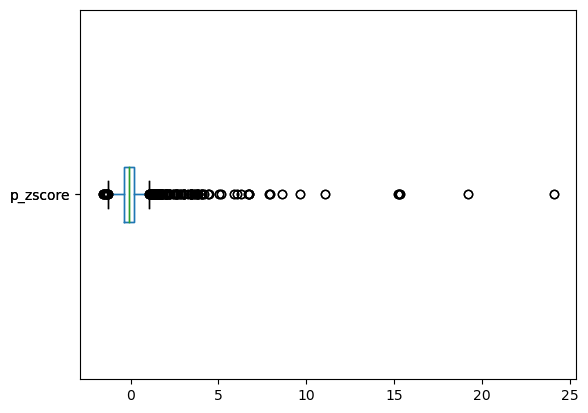

count    3008.000000
mean        0.009811
std         1.066385
min        -1.584670
25%        -0.401517
50%        -0.105970
75%         0.179277
max        24.092300
Name: p_zscore, dtype: float64

In [75]:
solar_1h.boxplot(column= 'p_zscore', vert= False, grid=False)
plt.show()
solar_1h.p_zscore.describe()

In [76]:
solar_1h['zscore_class'] = pd.cut(solar_1h.p_zscore, bins = [-2, .179277, 25], labels =[0,1])
solar_1h.drop(['p_zscore'], axis=1, inplace=True)
prevalence = solar_1h.zscore_class.value_counts()[1]/len(solar_1h.zscore_class)
prevalence

0.25

In [58]:
x = solar_1h.drop(columns = 'zscore_class', axis=1)
y = solar_1h.zscore_class

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, stratify= y, random_state=21)
x_tune, x_test, y_tune, y_test = train_test_split(x_test,y_test,  train_size = 0.50,stratify= y_test, random_state=49)

In [60]:
kf = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42)

In [61]:
from sklearn import metrics

y_true = solar_1h['zscore_class']

print(metrics.roc_auc_score)

<function roc_auc_score at 0x138e2bd80>


In [77]:
scoring = ['roc_auc','recall','balanced_accuracy']
param= {"max_depth" : [1,2,3,4,5,6,7,8,9,10,11]}

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Classifier model we will use
my_classifier = DecisionTreeClassifier(random_state=1000)

# Set up search for the best DecisionTreeClassifier estimator across all folds based on roc_auc
my_search = GridSearchCV(my_classifier, param, scoring=scoring, n_jobs=-1, cv=kf, refit='roc_auc', error_score='raise')

# Execute the search on our training data, this may take a few seconds ...
try:
    my_model = my_search.fit(x_train, y_train)
except ValueError as e:
    print(f"Error: {e}")

In [21]:
#Classifier model we will use
my_classifier= DecisionTreeClassifier(random_state=1000)

#Set up search for best decisiontreeclassifier estimator across all of our folds based on roc_auc
my_search = GridSearchCV(my_classifier, param, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')

#execute search on our training data, this may take a few seconds ...
my_model = my_search.fit(x_train, y_train)

In [78]:
best = my_model.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=10, random_state=1000)


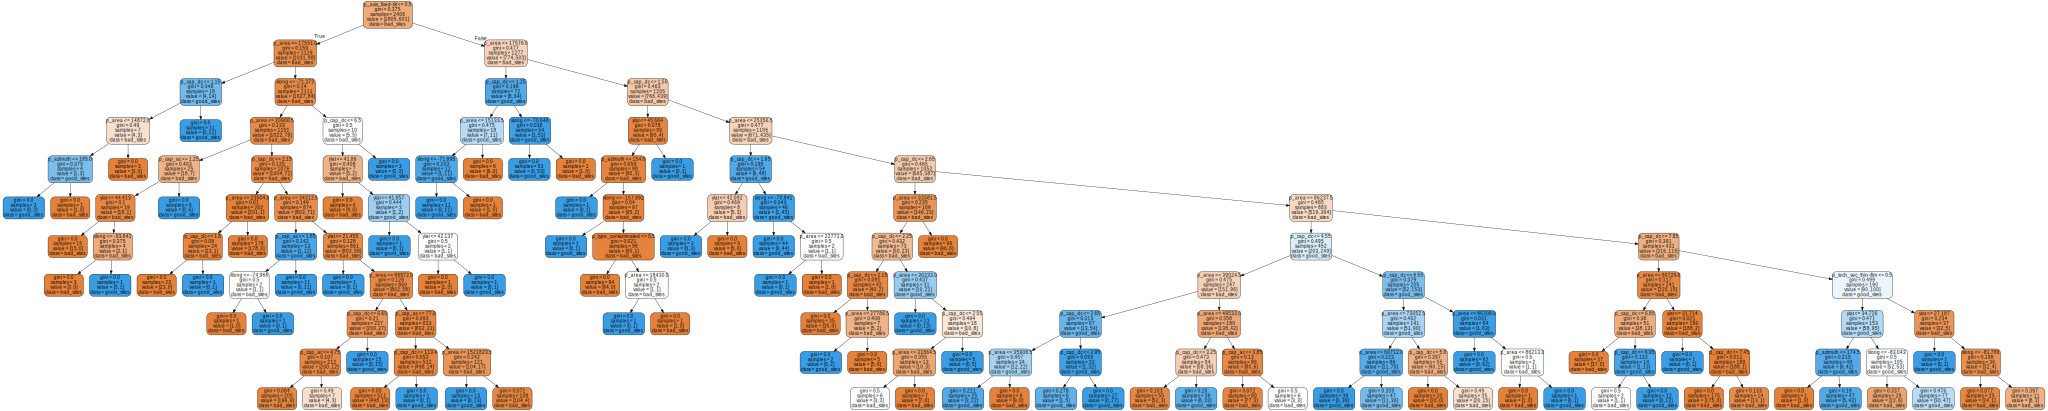

In [79]:
dot_data = export_graphviz(best, out_file =None,
               feature_names =x.columns, #feature names from dataset
               filled=True, 
                rounded=True, 
                class_names = ['bad_sites','good_sites']) #classification labels 
               
graph=graphviz.Source(dot_data)
graph

In [80]:
auc = my_model.cv_results_['mean_test_roc_auc']
recall= my_model.cv_results_['mean_test_recall']
bal_acc= my_model.cv_results_['mean_test_balanced_accuracy']

SDauc = my_model.cv_results_['std_test_roc_auc']
SDrecall= my_model.cv_results_['std_test_recall']
SDbal_acc= my_model.cv_results_['std_test_balanced_accuracy']

#Parameter:
depth= np.unique(my_model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

#Let's take a look
final_model.style.hide(axis='index')

depth,auc,recall,bal_acc,aucSD,recallSD,bal_accSD
1,0.704048,0.000000,0.500000,0.027596,0.000000,0.000000
2,0.733741,0.121481,0.555864,0.028465,0.036293,0.018108
3,0.746764,0.119137,0.554970,0.031813,0.036407,0.018714
4,0.773038,0.237634,0.603702,0.033858,0.134183,0.048036
5,0.795447,0.332126,0.644454,0.041805,0.183473,0.073540
6,0.830196,0.539902,0.725086,0.044977,0.166518,0.067526
7,0.857043,0.593404,0.762132,0.039913,0.086202,0.043846
8,0.870983,0.653650,0.792304,0.039236,0.113066,0.054551
9,0.884597,0.688290,0.814392,0.033470,0.092593,0.047104
10,0.891390,0.728820,0.835764,0.032229,0.088671,0.045162


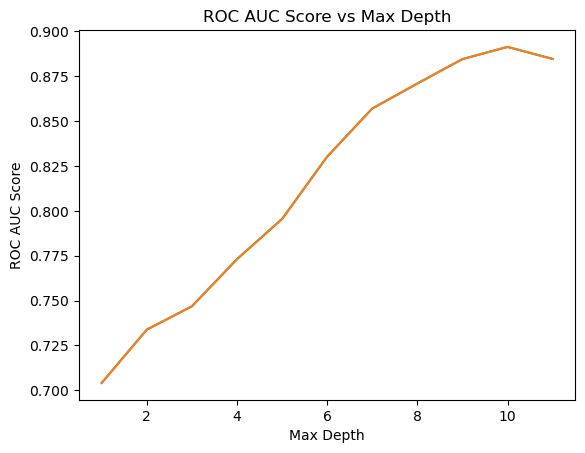

In [82]:
plt.plot(final_model['depth'], final_model['auc'])
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score vs Max Depth')
plt.show()

In [83]:
varimp=pd.DataFrame(best.feature_importances_,index = x.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

                            importance
p_area                        0.384133
p_cap_dc                      0.347228
p_axis_fixed-tilt             0.157980
ylat                          0.032341
xlong                         0.028092
p_cap_ac                      0.022265
p_tech_sec_thin-film          0.019656
p_azimuth                     0.006937
p_type_contaminated           0.001369
p_tech_sec_c-si               0.000000
p_tech_sec_combination        0.000000
p_tech_sec_cpv                0.000000
p_tilt                        0.000000
p_tech_sec_unknown            0.000000
p_axis_combination            0.000000
p_axis_dual-axis              0.000000
p_axis_single-axis            0.000000
p_type_greenfield             0.000000
p_type_landfill               0.000000
p_agrivolt_agrivoltaic        0.000000
p_agrivolt_non-agrivoltaic    0.000000


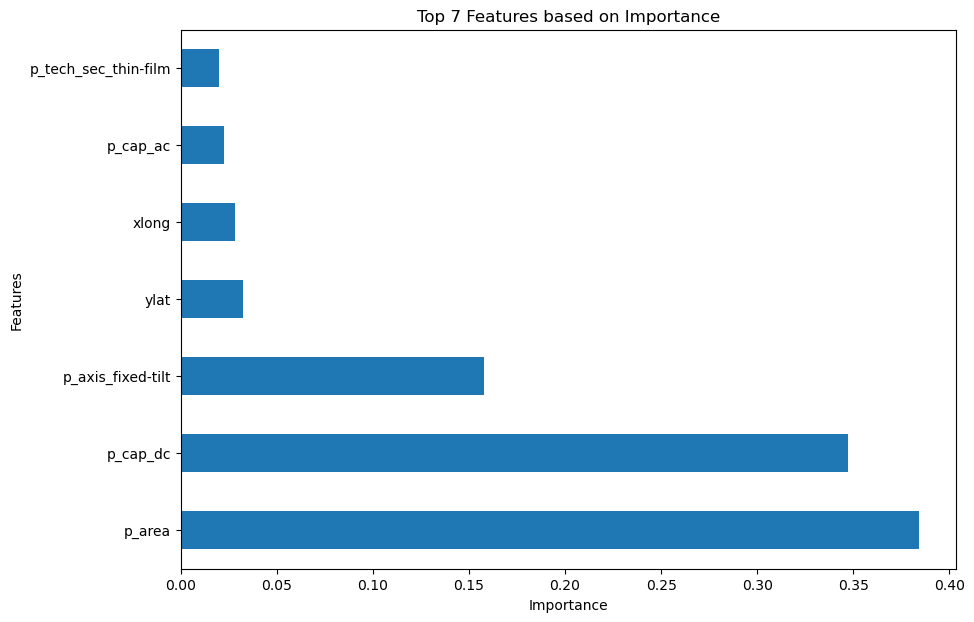

In [84]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 7))

# Plot the top 7 features based on importance
varimp.importance.nlargest(7).plot(kind='barh')

# Set labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 7 Features based on Importance')

# Show the plot
plt.show()


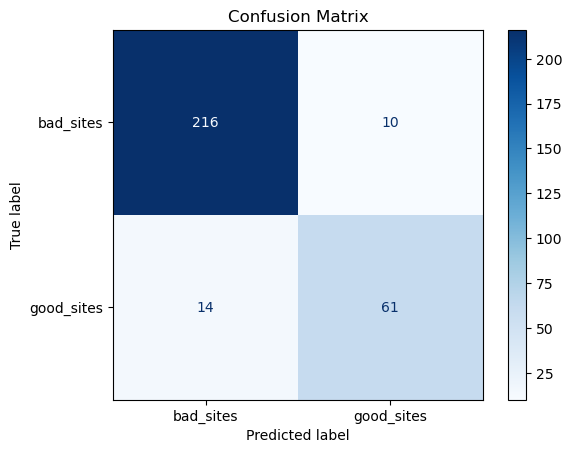

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'best' is your best-trained decision tree classifier
y_pred = best.predict(x_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad_sites', 'good_sites'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


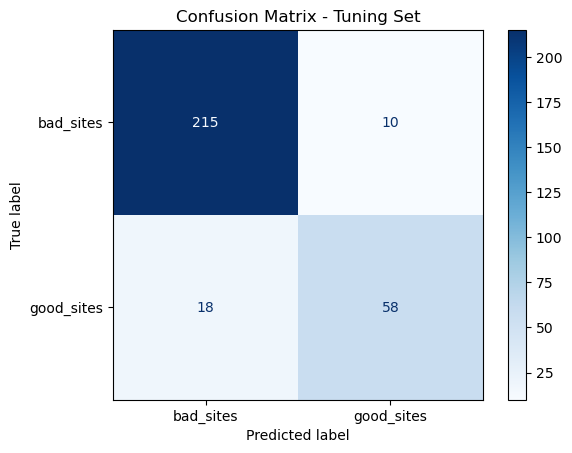

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'best' is your best-trained decision tree classifier
y_tune_pred = best.predict(x_tune)

# Compute confusion matrix
cm_tune = confusion_matrix(y_tune, y_tune_pred)

# Display confusion matrix
disp_tune = ConfusionMatrixDisplay(confusion_matrix=cm_tune, display_labels=['bad_sites', 'good_sites'])
disp_tune.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Tuning Set')
plt.show()


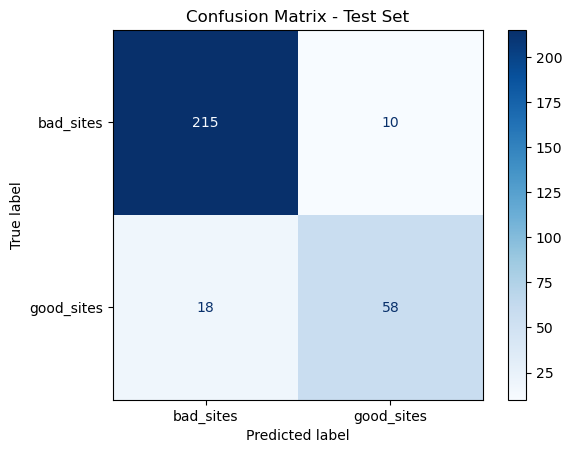

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'best' is your best-trained decision tree classifier
y_test_pred = best.predict(x_test)

# Compute confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
disp_tune = ConfusionMatrixDisplay(confusion_matrix=cm_tune, display_labels=['bad_sites', 'good_sites'])
disp_tune.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()

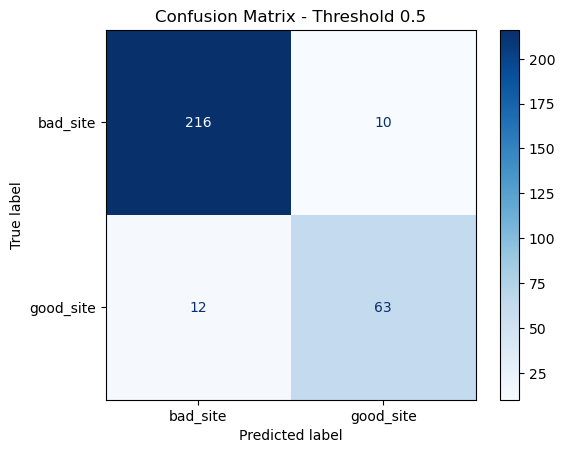

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def adjust_thres(model, X, y_true, thres):
    # model: best estimator
    # X: feature variables
    # y_true: true target variables
    # thres: threshold

    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]

    # Adjust predictions based on the threshold
    y_pred = (y_prob >= thres).astype(np.int32)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad_site', 'good_site'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Threshold {thres}')
    plt.show()

# Example usage
adjust_thres(best, x_test, y_test, thres=0.5)  # Replace 0.5 with your desired threshold


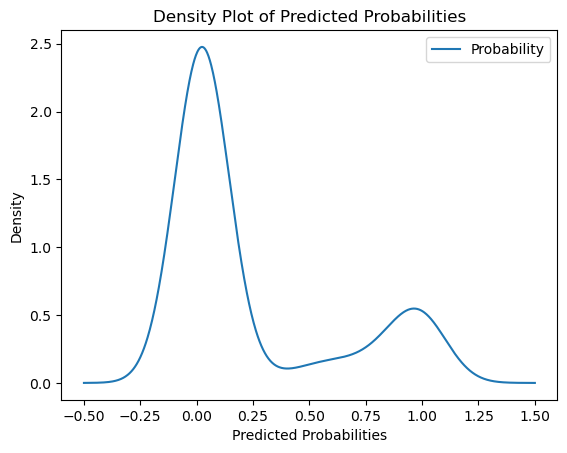

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'my_model' is your best-trained model
# Assuming 'x_tune' is your tuning set features

# Get the predicted probabilities for the positive class
probabilities = my_model.predict_proba(x_tune)[:, 1]

# Create a DataFrame with the probabilities
probabilities_df = pd.DataFrame(probabilities, columns=['Probability'])

# Plot the density plot
ax = probabilities_df.plot.density()
ax.set_xlabel('Predicted Probabilities')
ax.set_ylabel('Density')
ax.set_title('Density Plot of Predicted Probabilities')
plt.show()


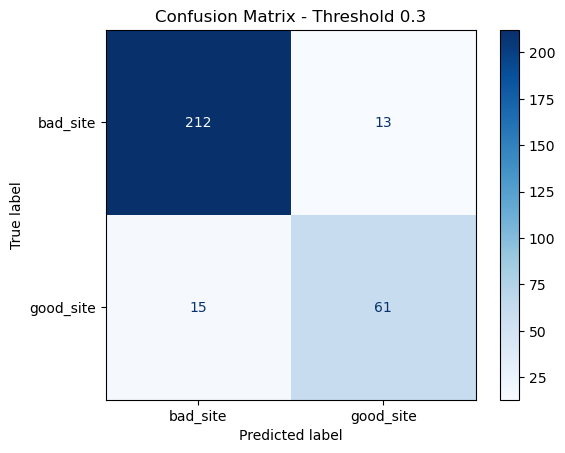

In [108]:
adjust_thres(best,x_tune, y_tune,.3)

In [109]:
test_accuracy = best.score(x_test, y_test)
print(f'Accuracy on the test set: {test_accuracy:.4f}')

Accuracy on the test set: 0.9203


In [102]:

tune_accuracy = best.score(x_tune, y_tune)
print(f'Accuracy on the tune set: {tune_accuracy:.4f}')


Accuracy on the tune set: 0.9070


In [103]:
print(pd.DataFrame(best.feature_importances_,index = x.columns,columns=['importance']).sort_values('importance', ascending=False))


                            importance
p_area                        0.384133
p_cap_dc                      0.347228
p_axis_fixed-tilt             0.157980
ylat                          0.032341
xlong                         0.028092
p_cap_ac                      0.022265
p_tech_sec_thin-film          0.019656
p_azimuth                     0.006937
p_type_contaminated           0.001369
p_tech_sec_c-si               0.000000
p_tech_sec_combination        0.000000
p_tech_sec_cpv                0.000000
p_tilt                        0.000000
p_tech_sec_unknown            0.000000
p_axis_combination            0.000000
p_axis_dual-axis              0.000000
p_axis_single-axis            0.000000
p_type_greenfield             0.000000
p_type_landfill               0.000000
p_agrivolt_agrivoltaic        0.000000
p_agrivolt_non-agrivoltaic    0.000000


In [110]:
y_pred = best.predict(x_test)
test_data = x_test.copy()
test_data['predicted_zscore'] = y_pred
top_sites = test_data.sort_values(by='predicted_zscore', ascending=False)
top_sites['true_zscore']= y_test.loc[top_sites.index].values
top_sites['state'] = solar_data.loc[top_sites.index, 'p_state'].values
top_sites['county'] = solar_data.loc[top_sites.index, 'p_county'].values
top_sites.head(10)

,ylat,xlong,p_area,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_tech_sec_c-si,p_tech_sec_combination,p_tech_sec_cpv,...,p_axis_single-axis,p_type_contaminated,p_type_greenfield,p_type_landfill,p_agrivolt_agrivoltaic,p_agrivolt_non-agrivoltaic,predicted_zscore,true_zscore,state,county
2309,42.187302,-76.894096,61941,180,20.0,4.0,5.5,True,False,False,...,False,False,True,False,False,True,1,1,NY,Chemung
865,38.216702,-122.542999,13285,180,30.0,0.8,1.1,True,False,False,...,False,False,True,False,False,True,1,1,CA,Sonoma
505,34.665001,-118.287003,18210,200,20.0,1.5,1.8,True,False,False,...,False,False,True,False,False,True,1,1,CA,Los Angeles
1082,25.644400,-80.488197,1075657,195,20.0,74.5,113.2,True,False,False,...,False,False,True,False,False,True,1,1,FL,Miami-Dade
2626,34.322201,-79.920403,185989,180,0.0,10.0,14.0,True,False,False,...,False,False,True,False,False,True,1,0,SC,Darlington
7,44.506302,-92.359802,78881,180,0.0,5.0,7.2,True,False,False,...,False,False,True,False,False,True,1,1,MN,Goodhue
1732,42.248199,-72.670601,30346,180,25.0,2.5,3.0,True,False,False,...,False,False,True,False,False,True,1,1,MA,Hampshire
2969,36.131599,-79.333504,81658,180,0.0,5.0,7.0,True,False,False,...,False,False,True,False,False,True,1,1,NC,Alamance
2350,42.198799,-75.928802,66877,180,20.0,4.9,6.1,True,False,False,...,False,False,True,False,False,True,1,1,NY,Broome
577,36.783699,-119.713997,12623,180,20.0,1.2,1.3,True,False,False,...,True,False,True,False,False,True,1,1,CA,Fresno


In [105]:
feature_importances = best.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False)
top_3_movies_features = top_sites[x.columns]
top_features

,Feature,Importance
2,p_area,0.384133
6,p_cap_dc,0.347228
14,p_axis_fixed-tilt,0.157980
0,ylat,0.032341
1,xlong,0.028092
5,p_cap_ac,0.022265
10,p_tech_sec_thin-film,0.019656
3,p_azimuth,0.006937
16,p_type_contaminated,0.001369
7,p_tech_sec_c-si,0.000000
